# Ikosahedral Anemoi Graph

In [1]:
import sys
sys.path.insert(0, "/home/rolan/all/anemoi-graphs/src")

In [2]:
from anemoi.graphs.create import GraphCreator

In [3]:
import anemoi.graphs.nodes
import os

builder_dir = "/home/rolan/all/anemoi-graphs/src/anemoi/graphs/nodes"
print("nodes available:", os.listdir(builder_dir))

nodes available: ['attributes.py', 'builders', '__init__.py', '__pycache__']


### Graph Test 1

In [5]:
from anemoi.graphs.create import GraphCreator
from omegaconf import OmegaConf

config = OmegaConf.create({
    "nodes": {
        "ico_nodes": {
            "node_builder": {
                "_target_": "anemoi.graphs.nodes.builders.from_refined_icosahedron.TriNodes",
                "resolution": 3,
                "name": "ico_nodes"
            },
            "attributes": {}
        }
    },
    "edges": [
        {
            "source_name": "ico_nodes",
            "target_name": "ico_nodes",
            "edge_builders": [
                {
                    "_target_": "anemoi.graphs.edges.builder.KNNEdges",
                    "source_name": "ico_nodes",
                    "target_name": "ico_nodes",
                    "num_nearest_neighbours": 6
                }
            ]
        }
    ]
})

creator = GraphCreator(config=config)
graph = creator.create()
print(graph)

No output path specified. The graph will not be saved.


HeteroData(
  ico_nodes={
    x=[642, 2],
    node_type='TriNodes',
  },
  (ico_nodes, to, ico_nodes)={
    edge_index=[2, 3852],
    edge_type='KNNEdges',
  }
)


### Graph Test 2

In [6]:
from omegaconf import OmegaConf
from anemoi.graphs.create import GraphCreator

config = OmegaConf.create({
    "nodes": {
        "ico_nodes": {
            "node_builder": {
                "_target_": "anemoi.graphs.nodes.builders.from_refined_icosahedron.TriNodes",
                "resolution": 4,  # more refined icosahedron, better global coverage
                "name": "ico_nodes"
            },
            "attributes": {}
        }
    },
    "edges": [
        {
            "source_name": "ico_nodes",
            "target_name": "ico_nodes",
            "edge_builders": [
                {
                    "_target_": "anemoi.graphs.edges.builder.KNNEdges",
                    "source_name": "ico_nodes",
                    "target_name": "ico_nodes",
                    "num_nearest_neighbours": 6
                }
            ]
        }
    ]
})

creator = GraphCreator(config)
graph = creator.create()

# Optional: check
print(graph)
print(graph.edge_types)
print(graph["ico_nodes", "to", "ico_nodes"])
print("edge_index" in graph["ico_nodes", "to", "ico_nodes"])

No output path specified. The graph will not be saved.


HeteroData(
  ico_nodes={
    x=[2562, 2],
    node_type='TriNodes',
  },
  (ico_nodes, to, ico_nodes)={
    edge_index=[2, 15372],
    edge_type='KNNEdges',
  }
)
[('ico_nodes', 'to', 'ico_nodes')]
{'edge_index': tensor([[   0,    1,    2,  ..., 2558, 2556, 2555],
        [   0,    0,    0,  ..., 2561, 2561, 2561]], dtype=torch.int32), 'edge_type': 'KNNEdges'}
True


### Check Coordinate Range

In [7]:
import numpy as np

# Extract coordinates from the graph (in radians)
coords = graph["ico_nodes"].x.numpy()
lats_deg = np.rad2deg(coords[:, 0])  # latitude
lons_deg = np.rad2deg(coords[:, 1])  # longitude

# Print stats
print("Longitude range (degrees):", lons_deg.min(), "to", lons_deg.max())
print("Latitude  range (degrees):", lats_deg.min(), "to", lats_deg.max())


Longitude range (degrees): -177.15991 to 180.0
Latitude  range (degrees): -90.0 to 90.0


### Visualize Graph for Check

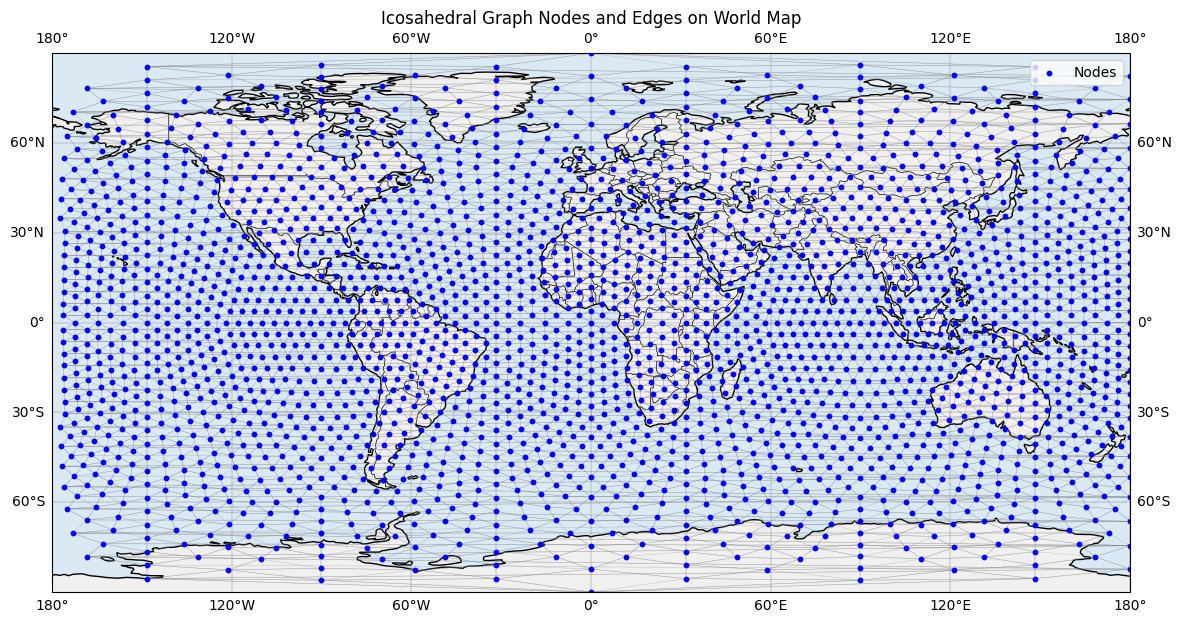

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract node coordinates (already in radians)
coords = graph["ico_nodes"].x.numpy()
lats_deg = np.rad2deg(coords[:, 0])  # latitude
lons_deg = np.rad2deg(coords[:, 1])  # longitude

# Extract edges
edges = graph["ico_nodes", "to", "ico_nodes"]["edge_index"].numpy()

# Create map plot with PlateCarree projection
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
# Light, dimmed colors
light_ocean = "#dbe9f4"   # very light blue
light_land  = "#f0f0f0"   # very light gray

# Apply light facecolors
ax.add_feature(cfeature.OCEAN, facecolor=light_ocean)
ax.add_feature(cfeature.LAND, facecolor=light_land)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.3, color='gray')

# Plot nodes
ax.scatter(lons_deg, lats_deg, s=10, color='blue', label='Nodes', zorder=3, transform=ccrs.PlateCarree())

# Plot edges
for i in range(edges.shape[1]):
    src = edges[0, i]
    tgt = edges[1, i]
    ax.plot(
        [lons_deg[src], lons_deg[tgt]],
        [lats_deg[src], lats_deg[tgt]],
        color='gray',
        linewidth=0.3,
        alpha=0.5,
        transform=ccrs.PlateCarree(),
        zorder=2
    )

plt.title("Icosahedral Graph Nodes and Edges on World Map")
plt.legend(loc='upper right')  # or any fixed location like 'lower left', 'center', etc.
plt.savefig("anemoi_graph_1.png")
plt.show()

### Globe Visualization

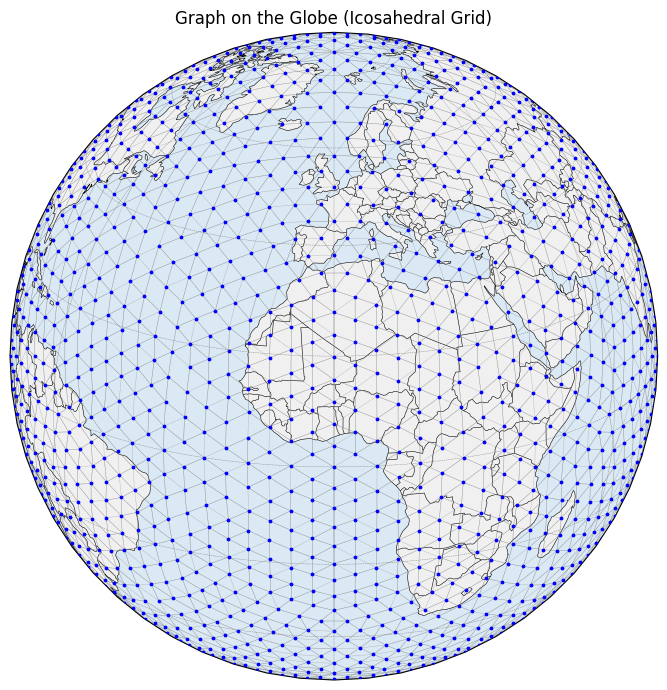

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Extract lat/lon in degrees from graph
coords = graph["ico_nodes"].x.numpy()
lats = np.rad2deg(coords[:, 0])  # first column is latitude
lons = np.rad2deg(coords[:, 1])  # second column is longitude

# Extract edges
edges = graph["ico_nodes", "to", "ico_nodes"]["edge_index"].numpy()

# Optional: Filter out edges with very long jumps in longitude (anti-meridian issues)
# lon_diff = np.abs(lons[edges[0]] - lons[edges[1]])
# valid = lon_diff < 180  # degrees
# edges = edges[:, valid]

# Setup globe plot
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=20))

# Light, dimmed colors
light_ocean = "#dbe9f4"   # very light blue
light_land  = "#f0f0f0"   # very light gray

# Background: land, ocean, borders
ax.add_feature(cfeature.LAND, facecolor=light_land, zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor=light_ocean, zorder=0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="black", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="black", zorder=1)
ax.gridlines(linewidth=0.3, color='gray', linestyle="--")

# Plot graph edges
for src, tgt in edges.T:
    ax.plot(
        [lons[src], lons[tgt]],
        [lats[src], lats[tgt]],
        color="gray",
        linewidth=0.3,
        alpha=0.5,
        transform=ccrs.Geodetic(),  # ensures great circle arcs
        zorder=2
    )

# Plot graph nodes
ax.scatter(lons, lats, s=3, color="blue", transform=ccrs.PlateCarree(), zorder=3)

plt.title("Graph on the Globe (Icosahedral Grid)")
plt.tight_layout()
plt.savefig("anemoi_graph_2.png", dpi=150)
plt.show()

In [ ]:
# --- Knoten Koordinaten in Grad ---
coords = graph["ico_nodes"].x.numpy()  # shape (N,2) in Radians
lats = np.rad2deg(coords[:, 0])
lons = np.rad2deg(coords[:, 1])

# --- Kanten ---
edges = graph["ico_nodes", "to", "ico_nodes"]["edge_index"].numpy()

# --- Funktion: sphärisch zu kartesisch ---
def sph2cart(lat, lon, r=1):
    lat_r = np.deg2rad(lat)
    lon_r = np.deg2rad(lon)
    x = r * np.cos(lat_r) * np.cos(lon_r)
    y = r * np.cos(lat_r) * np.sin(lon_r)
    z = r * np.sin(lat_r)
    return x, y, z

x_nodes, y_nodes, z_nodes = sph2cart(lats, lons)

# --- Kanten Linien-Koordinaten ---
edge_x, edge_y, edge_z = [], [], []
for src, tgt in edges.T:
    edge_x += [x_nodes[src], x_nodes[tgt], None]
    edge_y += [y_nodes[src], y_nodes[tgt], None]
    edge_z += [z_nodes[src], z_nodes[tgt], None]

# --- Kugel Oberfläche ---
phi, theta = np.mgrid[0:np.pi:50j, 0:2*np.pi:100j]
x_s = np.sin(phi) * np.cos(theta)
y_s = np.sin(phi) * np.sin(theta)
z_s = np.cos(phi)

sphere = go.Surface(
    x=x_s, y=y_s, z=z_s,
    colorscale=[[0, 'white'], [1, 'white']],
    opacity=0.1,
    showscale=False,
    hoverinfo='skip',
)

edges_3d = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='skip'
)

nodes_3d = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Nodes'
)

fig = go.Figure(data=[sphere, edges_3d, nodes_3d])

fig.update_layout(
    scene=dict(
        xaxis=dict(showbackground=False, visible=False),
        yaxis=dict(showbackground=False, visible=False),
        zaxis=dict(showbackground=False, visible=False),
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title='Anemoi Graph auf 3D Kugel (ohne Karte, ohne Achsen)',
    showlegend=False
)

fig.show()